In [0]:
import pickle
import numpy as np
from matplotlib import pyplot as plt 

In [2]:
from google.colab import files
files.upload()
# choose the file on your computer to upload it then


Saving test_image.pkl to test_image.pkl
Saving train_image.pkl to train_image.pkl
Saving train_label.pkl to train_label.pkl


In [0]:
with open('train_image.pkl', 'rb') as ftr:
    train_image = pickle.load(ftr)
with open('test_image.pkl', 'rb') as fti:
    test_image = pickle.load(fti)
with open('train_label.pkl', 'rb') as ftl:
    train_labels = pickle.load(ftl)

In [0]:
train_image = np.matrix(train_image)
train_label = np.matrix(train_labels)
test_image  = np.matrix(test_image)

In [5]:
train_image.shape,test_image.shape,train_label.shape

((8000, 784), (2000, 784), (1, 8000))

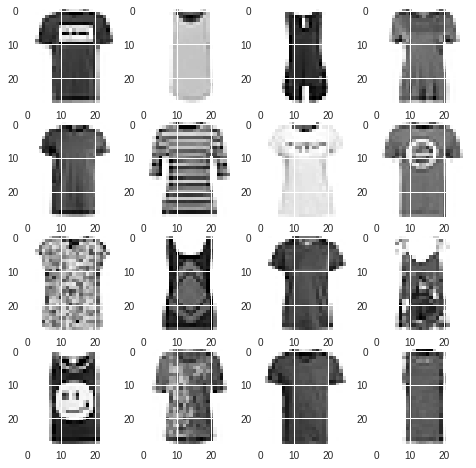

In [6]:
fig=plt.figure(figsize=(8,8))
for i in range(16):
    ax=fig.add_subplot(4,4,i+1)
    temp = train_image[i].reshape(28,28)
    ax.imshow(temp)
plt.show()

In [0]:
Y = train_label.T

In [0]:
def one_hot_encoding(Y):
    label = np.zeros((Y.shape[0],7))
    for y in range(Y.shape[0]):
        temp = np.zeros((1,7))
        temp[0,Y[y]] = 1
        label[y,:] = temp
    return label
    
    

In [0]:
Y = one_hot_encoding(Y)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x_train,x_test,y_train,y_test = train_test_split(train_image,Y,random_state = 1)

In [0]:
import tensorflow as tf

In [0]:
input_width = 28
input_height = 28
input_channels = 1
input_size = 784

In [0]:
n_conv1 = 64
n_conv2 = 128

n_dense = 2048
n_out = 7

In [0]:
k1 = 5
k2 = 5

stride1 = 1
stride2 = 1

pool1_k = 2
pool2_k = 2

# TODO: Stride is not considered in this
# TODO: what if the sizes are odd
pool2_output_size = (input_width//(pool1_k*pool2_k))*(input_height//(pool1_k*pool2_k))*n_conv2

In [16]:
weights = {
    "wc1" : tf.Variable(tf.random_normal([k1, k1, input_channels, n_conv1])),
    "wc2" : tf.Variable(tf.random_normal([k2, k2, n_conv1, n_conv2])),
    "wh1" : tf.Variable(tf.random_normal([pool2_output_size, n_dense])),
    "wo"  : tf.Variable(tf.random_normal([n_dense, n_out])),
}

biases = {
    "bc1" : tf.Variable(tf.random_normal([n_conv1])),
    "bc2" : tf.Variable(tf.random_normal([n_conv2])),
    "bh1" : tf.Variable(tf.random_normal([n_dense])),
    "bo"  : tf.Variable(tf.random_normal([n_out]))
}

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def conv(images, weights, biases, stride=1):
    out = tf.nn.conv2d(images, weights, padding ="SAME", strides = [1, stride, stride, 1])
    out = tf.nn.bias_add(out, biases)
    out = tf.nn.relu(out)
    return out

def maxpooling(images, k = 2):
    return tf.nn.max_pool(images, ksize=[1,k,k,1], padding = "SAME", strides=[1,k,k,1])    

In [0]:
def cnn(x, weights, biases):
    images = tf.reshape(x, shape=[-1, input_height, input_width, input_channels])
    conv1 = conv(images, weights['wc1'], biases['bc1'], stride1)
    conv1_pool = maxpooling(conv1, pool1_k)
    
    conv2 = conv(conv1_pool, weights['wc2'], biases['bc2'], stride2)
    conv2_pool = maxpooling(conv2, pool2_k)
    
    dense_input = tf.reshape(conv2_pool, shape=[-1, pool2_output_size])
    dense_output_before_activation = tf.add(tf.matmul(dense_input, weights['wh1']), biases['bh1'])
    dense_output = tf.nn.relu(dense_output_before_activation)
    
    output = tf.add(tf.matmul(dense_output, weights['wo']), biases['bo'])
    return output

In [0]:
x = tf.placeholder("float", [None, input_size])
y = tf.placeholder(tf.int32, [None, n_out])

pred = cnn(x, weights, biases)

In [0]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels = y))

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
optimize = optimizer.minimize(cost)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [24]:
for i in range(150):
  c, _ = sess.run([cost, optimize], feed_dict={x:x_train, y:y_train})
print(c)

0.0


In [0]:
prediction = tf.argmax(pred,1)
correct_label = tf.argmax(y,1)
correct_prediction = tf.equal(prediction,correct_label)
prediction,correct_preds = sess.run([prediction,correct_prediction],feed_dict = {x:x_test,y:y_test})

In [26]:
prediction

array([3, 3, 6, ..., 2, 0, 0])

In [27]:
correct_preds.sum()

1560

In [28]:
x_test.shape

(2000, 784)

In [0]:
prediction = tf.argmax(pred,1)
predictions = sess.run([prediction],feed_dict = {x:test_image})

In [30]:
len(predictions[0]),len(test_image)

(2000, 2000)

In [0]:
pred = np.array(predictions).T
image_index = np.array([i for i in range(pred.shape[0])]).reshape(-1,1)
result = np.concatenate((image_index,pred),axis = 1)


In [32]:
image_index.shape,pred.shape,result.shape



((2000, 1), (2000, 1), (2000, 2))

In [0]:
#np.savetxt('result.csv',result,header= 'image_index , class')

In [0]:
from google.colab import files

with open('result.csv', 'w') as f:
  np.savetxt(f,result,header = 'image_index,classes',fmt = '%i',delimiter=',')

files.download('result.csv')

In [36]:
result.shape

(2000, 2)

In [0]:
c,v = np.unique(pred,return_counts=True)

In [50]:
c,v

(array([0, 2, 3, 6]), array([483, 505, 503, 509]))

In [0]:
f,h =np.unique(np.array(prediction),return_counts = True)

In [57]:
f,h

(array([<tf.Tensor 'ArgMax_2:0' shape=(?,) dtype=int64>], dtype=object),
 array([1]))